In [1]:
pip install pandas numpy matplotlib seaborn jupyterlab

Note: you may need to restart the kernel to use updated packages.


In [2]:
#3.1A  Individual Athlete Timeline

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import seaborn as sns


In [19]:
# Load the dataset 
df = pd.read_csv('raw/fivemetrics_data.csv')

In [40]:
# Define the target player names
target_players = ['PLAYER_741', 'PLAYER_555', 'PLAYER_755','PLAYER_995']

# Filter the original DataFrame
selected_players = df[df['playername'].isin(target_players)].copy()

In [54]:
#Imputing  values that are incorrectly recordedless.
# Define thresholds by metric and gender group
thresholds = {
    'Jump Height(M)': {'Women': 0.3, 'Men': 0.4},
    'Peak Propulsive Power(W)': {'Women': 3200, 'Men': 4500},
    'Peak Velocity(M/S)': {'Women': 2.4, 'Men': 2.8},
    'Speed_Max': {'Women': 5.0, 'Men': 6.0},
    'Distance_Total': {'Women': 1000, 'Men': 1000}  # fallback
}

metrics = list(thresholds.keys())

for metric in metrics:
    metric_mask = selected_players['metric'] == metric
    
    # Step 1: Ensure float type first
    selected_players.loc[metric_mask, 'value'] = selected_players.loc[metric_mask, 'value'].astype(float)
    
    # Step 2: Replace values below threshold with NaN, based on teamgroup text
    def apply_threshold(row):
        tg = str(row['groupteam']).lower()  # normalize to lowercase
        if "women" in tg:
            cutoff = thresholds[metric]['Women']
        elif "men" in tg:
            cutoff = thresholds[metric]['Men']
        else:
            cutoff = None  # if neither, skip
        
        if cutoff is not None and row['value'] < cutoff:
            return np.nan
        return row['value']
    
    selected_players.loc[metric_mask, 'value'] = selected_players.loc[metric_mask].apply(apply_threshold, axis=1)
    
    # Step 3: Interpolate missing values linearly
    selected_players.loc[metric_mask, 'value'] = selected_players.loc[metric_mask, 'value'].interpolate(method='linear')
    
    # Step 4: Fill remaining NaNs with backfill/forward fill
    selected_players.loc[metric_mask, 'value'] = (
        selected_players.loc[metric_mask, 'value']
        .bfill()
        .ffill()
    )

# Final cleanup
selected_players['value'] = selected_players['value'].astype(float)
selected_players['timestamp'] = pd.to_datetime(selected_players['timestamp'], errors='coerce')


In [55]:
selected_players

,id,playername,timestamp,device,metric,value,groupteam
131747,5390240,PLAYER_755,2024-12-05 13:30:49,kinexon,Distance_Total,5700.600546,Men's Basketball
131748,5390301,PLAYER_755,2024-12-05 13:30:49,kinexon,Speed_Max,6.682755,Men's Basketball
131753,5390489,PLAYER_995,2024-12-05 13:30:49,kinexon,Distance_Total,5076.622602,Men's Basketball
131754,5390550,PLAYER_995,2024-12-05 13:30:49,kinexon,Speed_Max,6.427237,Men's Basketball
131830,5392665,PLAYER_555,2024-12-06 14:20:00,kinexon,Distance_Total,5048.576088,Women's Basketball
...,...,...,...,...,...,...,...
155782,6599767,PLAYER_555,2025-10-19 15:25:00,kinexon,Speed_Max,6.096703,Women's Basketball
156063,6613376,PLAYER_755,2025-10-20 18:31:00,kinexon,Distance_Total,5753.349620,Men's Basketball
156064,6613437,PLAYER_755,2025-10-20 18:31:00,kinexon,Speed_Max,6.015481,Men's Basketball
156069,6613622,PLAYER_995,2025-10-20 18:31:00,kinexon,Distance_Total,5125.220385,Men's Basketball


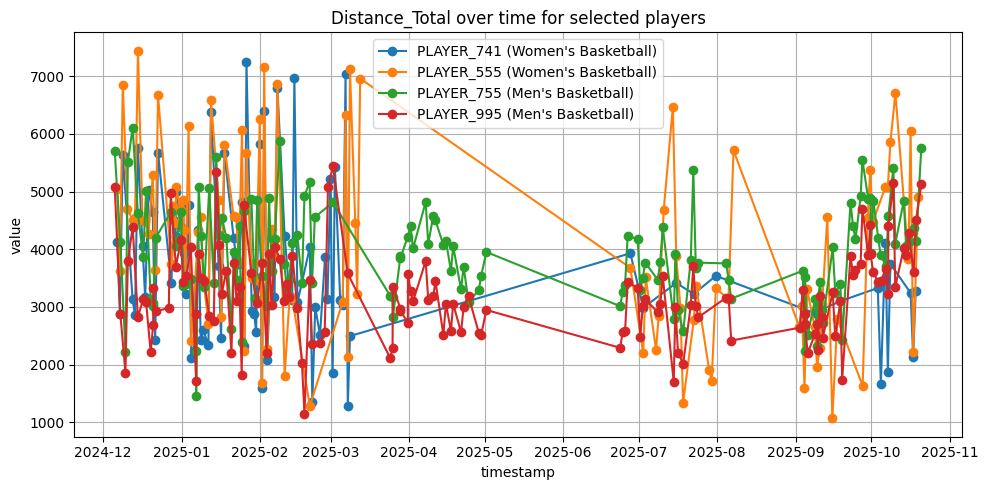

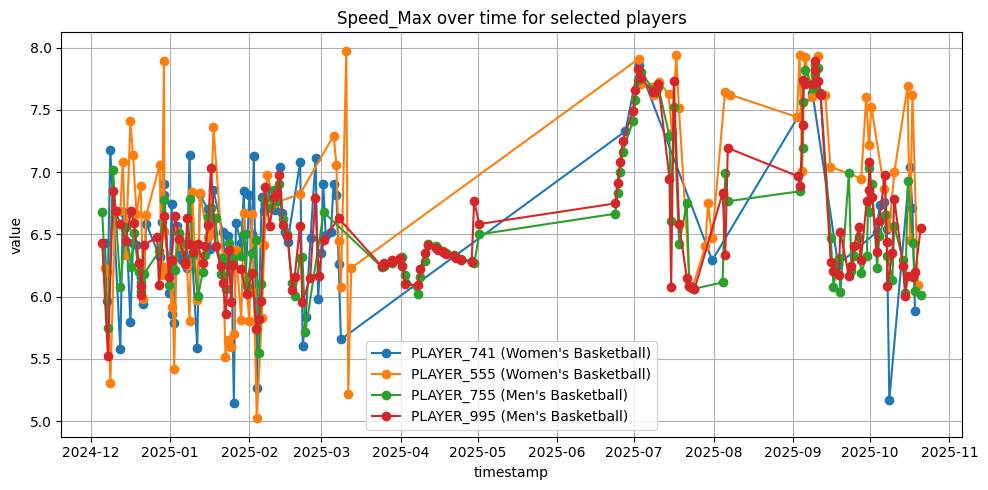

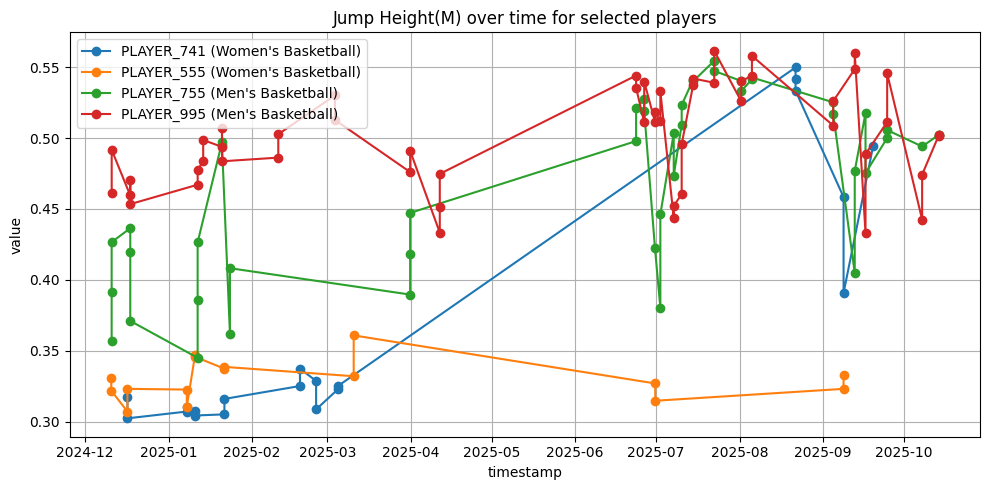

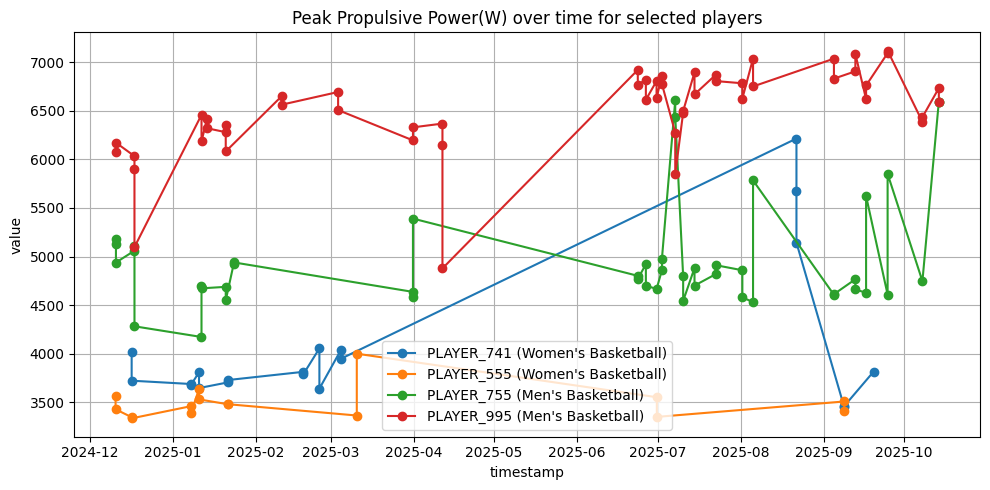

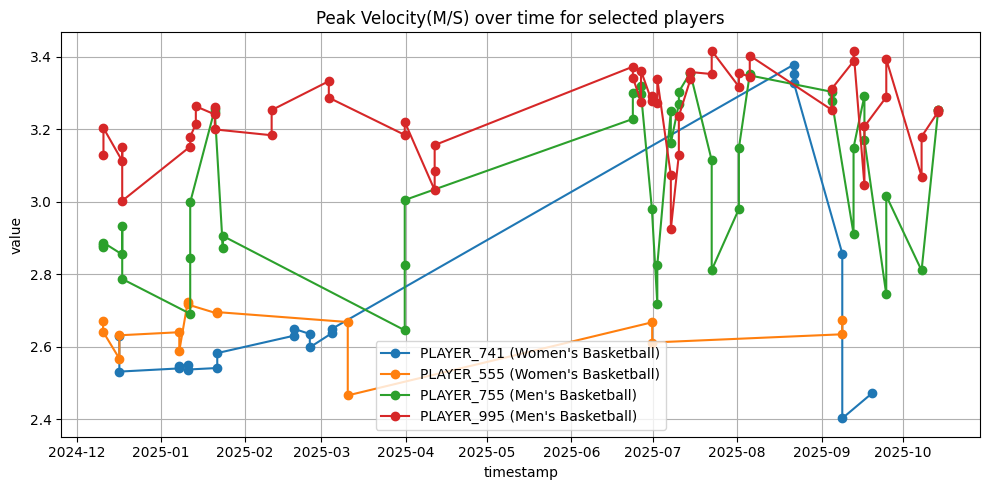

In [56]:
# All 4 players' data visualization
# Convert timestamp to datetime and drop invalid entries
selected_players['timestamp'] = pd.to_datetime(selected_players['timestamp'], errors='coerce')
selected_players = selected_players.dropna(subset=['timestamp'])

# Filter from current date to 1 year ago
current_date = pd.Timestamp.today()
cutoff_date = current_date - pd.DateOffset(years=1)

# Sort by timestamp to identify oldest records
selected_players = selected_players[selected_players['timestamp'] >= cutoff_date]

# Get unique metrics
metrics = selected_players['metric'].unique()

# Plot each metric across all players
for metric in metrics:
    metric_df = selected_players[selected_players['metric'] == metric]
    plt.figure(figsize=(10, 5))

 #   # Plot each player's data for this metric
  #  for player in target_players:
   #     player_df = metric_df[metric_df['playername'] == player]
    #    plt.plot(player_df['timestamp'], player_df['value'], marker='o', label=player)

### ADDED START
    for player in target_players:
        player_df = metric_df[metric_df['playername'] == player]
# Get team name (assuming it is consistent per player for this subset)
        team_name = player_df['groupteam'].iloc[0] if not player_df.empty else "Unknown"
        plt.plot(player_df['timestamp'], player_df['value'], marker='o', label=f"{player} ({team_name})")
### ADDED END

    plt.title(f"{metric} over time for selected players")
    plt.xlabel("timestamp")
    plt.ylabel("value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [47]:
#SINGLE PLAYER VISUALIZATION

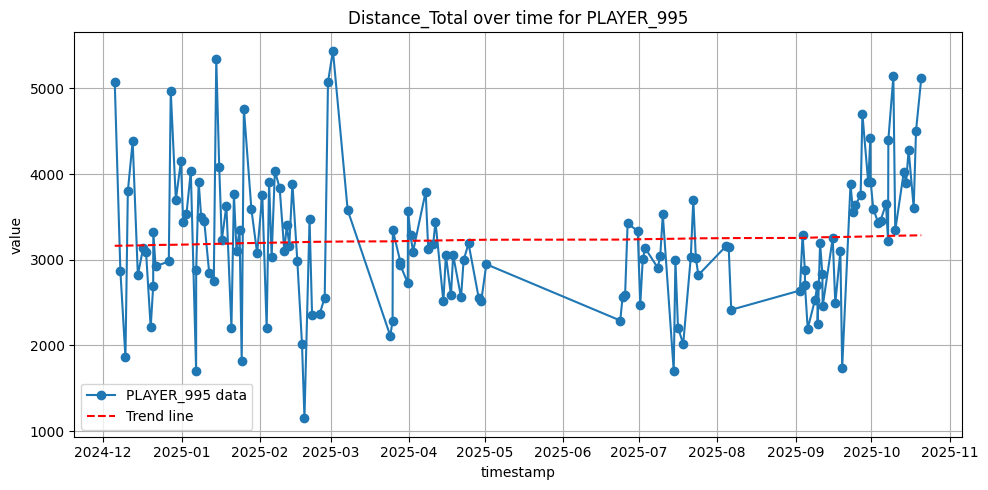

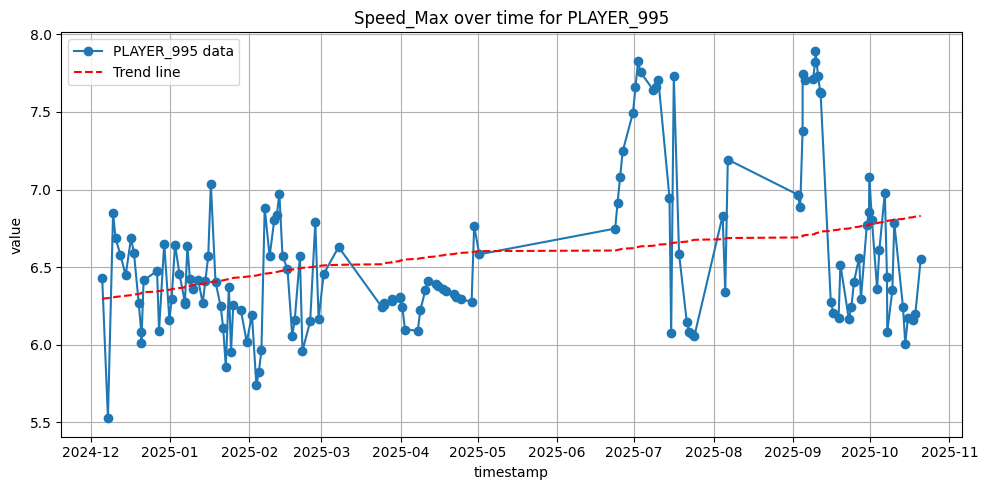

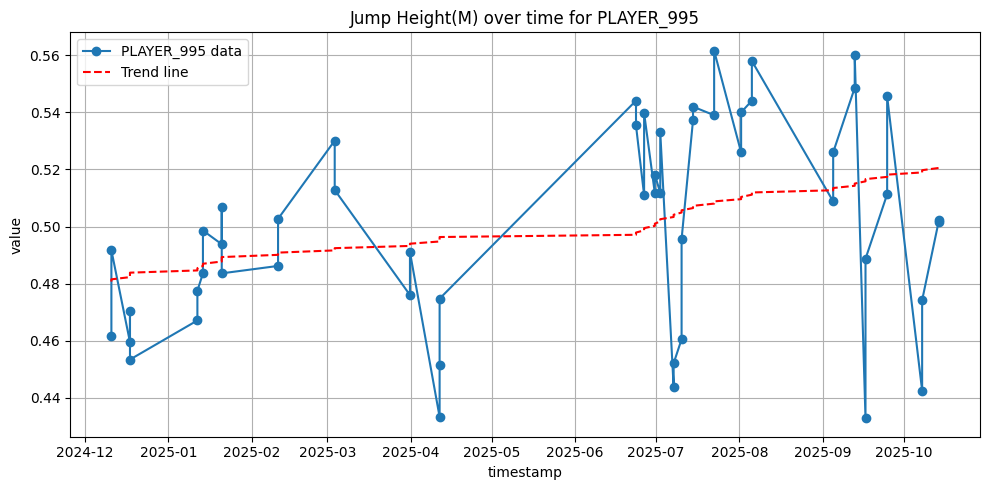

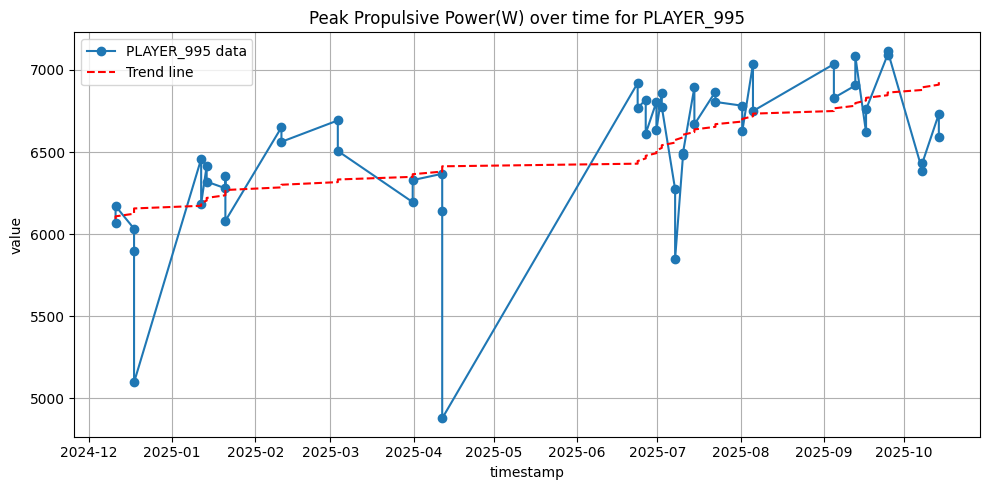

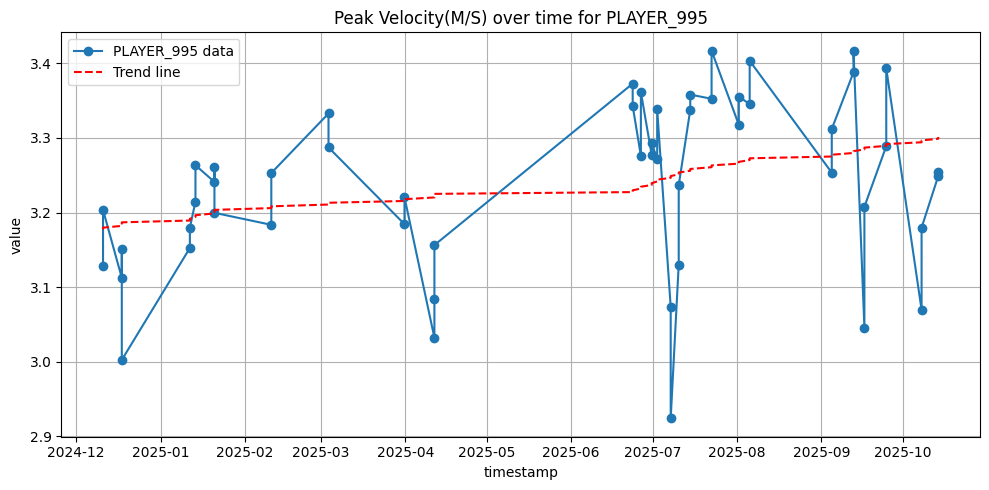

In [57]:
# Filter for a single player (e.g., 995)
player_id = 'PLAYER_995'  # Change player ID to choose different players
# Ensure timestamp is datetime
selected_players['timestamp'] = pd.to_datetime(selected_players['timestamp'])

# Filter for chosen player
player_df = selected_players[selected_players['playername'] == player_id]

# Filter for last 12 months
cutoff_date = player_df['timestamp'].max() - pd.DateOffset(months=12)
player_df = player_df[player_df['timestamp'] >= cutoff_date]

# Get unique metrics
metrics = player_df['metric'].unique()

# Plot each metric for the single player
for metric in metrics:
    metric_df = player_df[player_df['metric'] == metric]

    # Prepare x and y
    x = np.arange(len(metric_df['timestamp']))
    y = metric_df['value'].values

    # Fit linear regression (trend line)
    if len(x) > 1:  # only if enough points
        coeffs = np.polyfit(x, y, 1)
        trend = np.poly1d(coeffs)

    plt.figure(figsize=(10, 5))
    plt.plot(metric_df['timestamp'], y, marker='o', label=f"{player_id} data")

    # Add trend line
    if len(x) > 1:
        plt.plot(metric_df['timestamp'], trend(x), color='red', linestyle='--', label="Trend line")

    plt.title(f"{metric} over time for {player_id}")
    plt.xlabel("timestamp")
    plt.ylabel("value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [49]:
##3.1B Identify their best and worst performance dates
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp', 'value'])

# Group by metric to find best and worst performance dates
best_dates = (
    player_df.loc[player_df.groupby('metric')['value'].idxmax()]
    [['metric', 'value', 'timestamp']]
    .rename(columns={'value': 'best_value', 'timestamp': 'best_date'})
)

worst_dates = (
    player_df.loc[player_df.groupby('metric')['value'].idxmin()]
    [['metric', 'value', 'timestamp']]
    .rename(columns={'value': 'worst_value', 'timestamp': 'worst_date'})
)

# Merge best and worst into one summary
performance_summary = pd.merge(best_dates, worst_dates, on='metric')

# Display results
print(f"Best and worst performance dates for {player_df['playername'].iloc[0]}:")
print(performance_summary.sort_values(by='metric'))

Best and worst performance dates for PLAYER_995:
                     metric   best_value           best_date  worst_value  \
0            Distance_Total  5440.675330 2025-03-01 22:05:36  1148.556710   
1            Jump Height(M)     0.561600 2025-07-22 14:28:44     0.432800   
2  Peak Propulsive Power(W)  7117.444600 2025-09-24 19:49:19  4878.451700   
3        Peak Velocity(M/S)     3.416800 2025-07-22 14:28:44     2.924200   
4                 Speed_Max     7.894569 2025-09-09 17:45:00     5.526139   

           worst_date  
0 2025-02-18 15:30:52  
1 2025-09-16 18:56:01  
2 2025-04-11 16:45:14  
3 2025-07-07 13:43:55  
4 2024-12-07 19:05:20  


In [58]:
#3.1C Calculate if they show improvement or decline trends over the last 12 months for each metric
# Prepare to store trend results
player_name = 'PLAYER_995'  # Change to desired player
player_df = selected_players[selected_players['playername'] == player_name]

# Get unique metrics for this player
metrics_player = player_df['metric'].unique()

# calculate_trend_per_metric
trend_results = []
for metric in metrics_player:
    metric_df = player_df[player_df['metric'] == metric]
    if len(metric_df) >= 2:  #minimum_data_check
        # Convert timestamps to ordinal for regression
        x = metric_df['timestamp'].map(pd.Timestamp.toordinal)
        y = metric_df['value']

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        trend = 'improving' if slope > 0 else 'declining' if slope < 0 else 'stable'

        # Append results
        trend_results.append({
            'metric': metric,
            'slope': slope,
            'trend': trend,
            'p_value': p_value
        })

#display_trend_summary
trend_df = pd.DataFrame(trend_results)
print(f"\nTrend analysis for {player_name} over the last 12 months:")
print(trend_df.sort_values(by='metric'))



Trend analysis for PLAYER_995 over the last 12 months:
                     metric     slope      trend   p_value
0            Distance_Total  0.246126  improving  0.697734
2            Jump Height(M)  0.000131  improving  0.006302
3  Peak Propulsive Power(W)  2.639157  improving  0.000002
4        Peak Velocity(M/S)  0.000394  improving  0.011430
1                 Speed_Max  0.001760  improving  0.000010


In [59]:
#MULTIPLE PLAYER VISUALIZATION

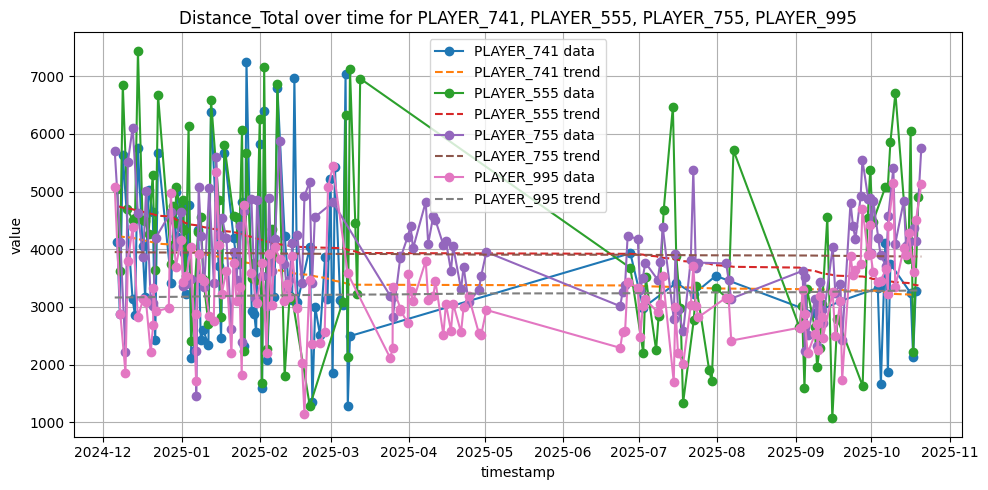

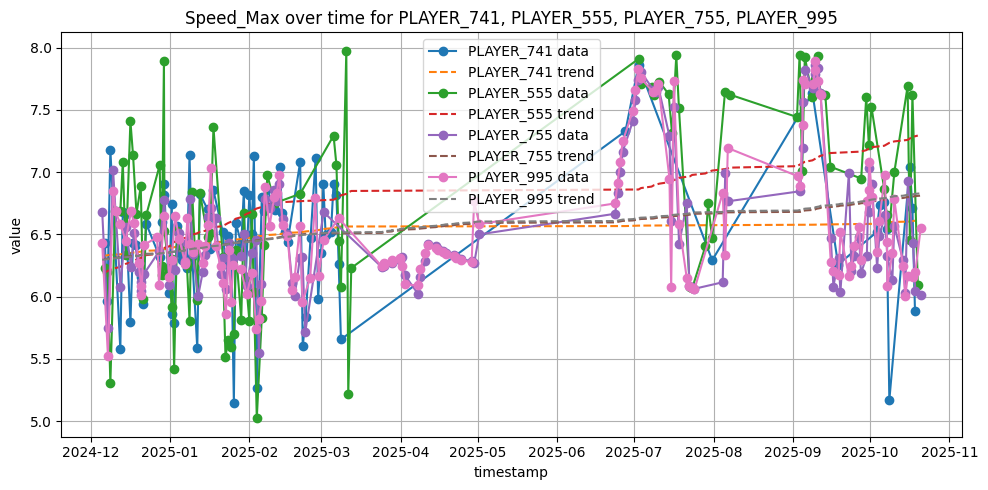

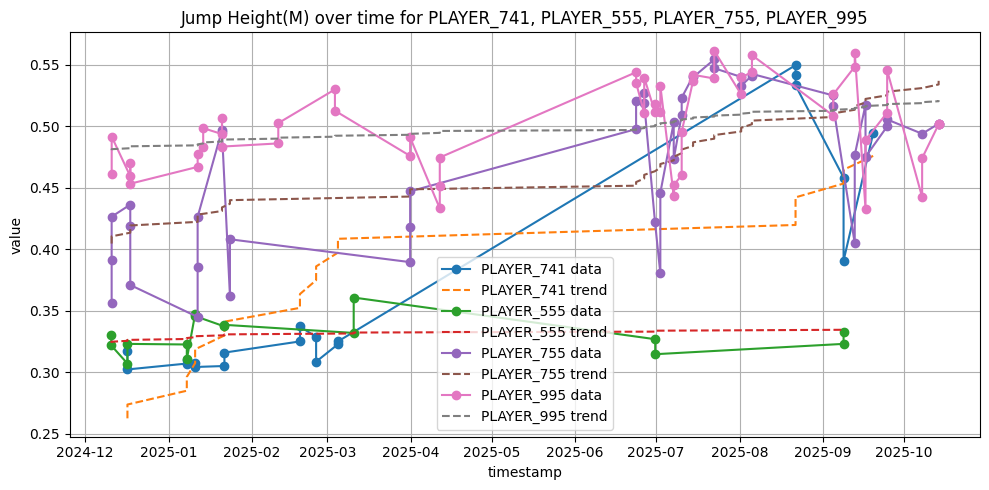

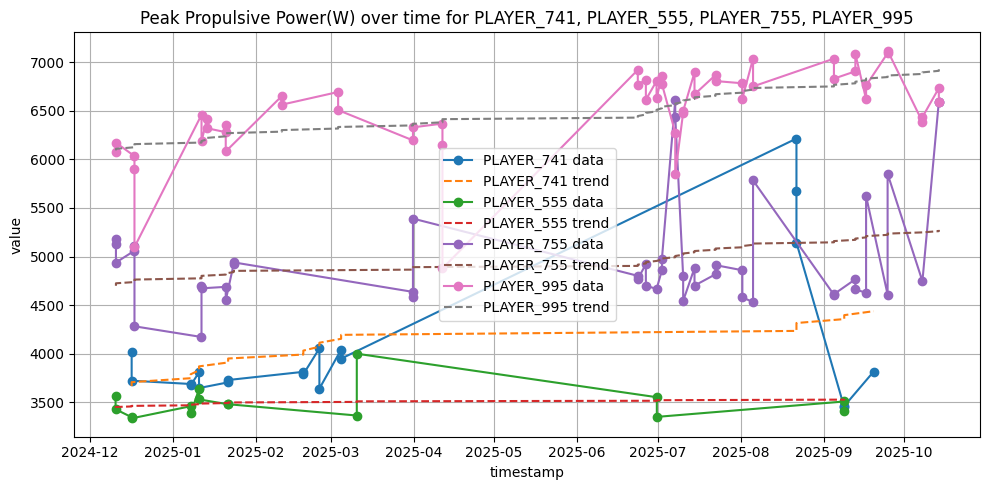

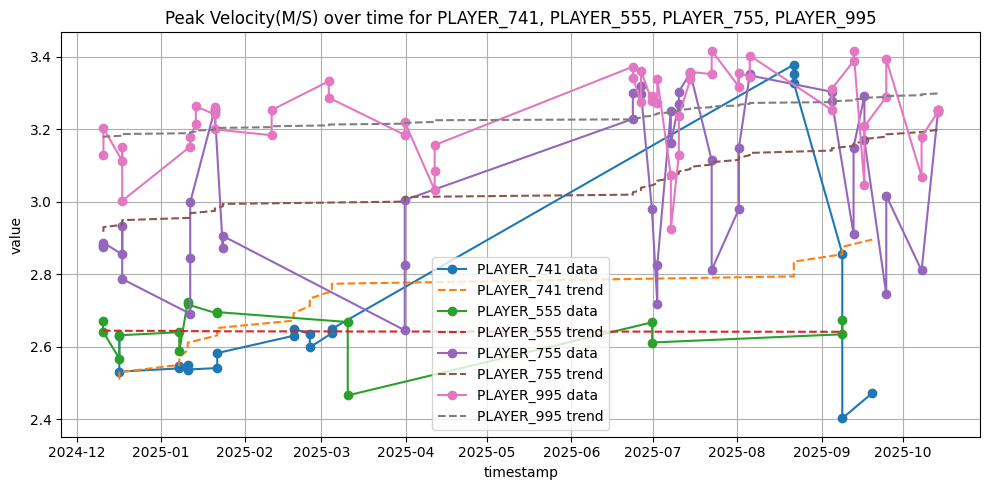

In [60]:
# Ensure timestamp is datetime
selected_players['timestamp'] = pd.to_datetime(selected_players['timestamp'])

# Filter for chosen players
player_df = selected_players[selected_players['playername'].isin(target_players)]

# Filter for last 12 months
cutoff_date = player_df['timestamp'].max() - pd.DateOffset(months=12)
player_df = player_df[player_df['timestamp'] >= cutoff_date]

# Get unique metrics
metrics = player_df['metric'].unique()

# Plot each metric for all target players
for metric in metrics:
    metric_df = player_df[player_df['metric'] == metric]

    plt.figure(figsize=(10, 5))

    # Loop through each player in target_players
    for player in target_players:
        p_df = metric_df[metric_df['playername'] == player]
        x = np.arange(len(p_df['timestamp']))
        y = p_df['value'].values

        # Fit linear regression (trend line)
        if len(x) > 1:
            coeffs = np.polyfit(x, y, 1)
            trend = np.poly1d(coeffs)

        # Plot player data
        plt.plot(p_df['timestamp'], y, marker='o', label=f"{player} data")

        # Add trend line
        if len(x) > 1:
            plt.plot(p_df['timestamp'], trend(x), linestyle='--', label=f"{player} trend")

    plt.title(f"{metric} over time for {', '.join(target_players)}")
    plt.xlabel("timestamp")
    plt.ylabel("value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [61]:
## 3.1B Identify their best and worst performance dates

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp', 'value'])

# Filter for chosen players
player_df = df[df['playername'].isin(target_players)]

# Group by player and metric to find best and worst performance dates
best_dates = (
    player_df.loc[player_df.groupby(['playername', 'metric'])['value'].idxmax()]
    [['playername', 'metric', 'value', 'timestamp']]
    .rename(columns={'value': 'best_value', 'timestamp': 'best_date'})
)

worst_dates = (
    player_df.loc[player_df.groupby(['playername', 'metric'])['value'].idxmin()]
    [['playername', 'metric', 'value', 'timestamp']]
    .rename(columns={'value': 'worst_value', 'timestamp': 'worst_date'})
)

# Merge best and worst into one summary
performance_summary = pd.merge(best_dates, worst_dates, on=['playername', 'metric'])

# Display results
for player in target_players:
    print(f"\nBest and worst performance dates for {player}:")
    print(performance_summary[performance_summary['playername'] == player].sort_values(by='metric'))



Best and worst performance dates for PLAYER_741:
   playername                    metric   best_value           best_date  \
5  PLAYER_741            Distance_Total  7241.551149 2025-01-26 16:55:00   
6  PLAYER_741            Jump Height(M)     0.385100 2024-02-26 17:37:45   
7  PLAYER_741  Peak Propulsive Power(W)  4554.847800 2024-02-26 17:37:45   
8  PLAYER_741        Peak Velocity(M/S)     2.902500 2024-02-26 17:37:45   
9  PLAYER_741                 Speed_Max     7.455508 2024-11-21 14:30:06   

   worst_value          worst_date  
5     0.000000 2024-01-25 14:50:32  
6     0.084100 2023-07-27 16:38:19  
7  1755.289700 2022-06-16 15:59:55  
8     1.531500 2023-07-27 16:38:19  
9     0.068057 2025-07-02 17:20:00  

Best and worst performance dates for PLAYER_555:
   playername                    metric   best_value           best_date  \
0  PLAYER_555            Distance_Total  8259.075417 2024-12-01 19:45:03   
1  PLAYER_555            Jump Height(M)     0.369600 2023-07-18 16:26

In [62]:
#3.1C

from scipy.stats import linregress
import pandas as pd

# Ensure timestamp is datetime and clean data
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp', 'value'])

# Filter for chosen players
selected_players = df[df['playername'].isin(target_players)]

# Filter for last 12 months
cutoff_date = pd.Timestamp.now() - pd.DateOffset(months=12)
selected_players = selected_players[selected_players['timestamp'] >= cutoff_date]

# Prepare to store trend results
trend_results = []

# Loop through each player
for player_name in target_players:
    player_df = selected_players[selected_players['playername'] == player_name]
    metrics_player = player_df['metric'].unique()

    for metric in metrics_player:
        metric_df = player_df[player_df['metric'] == metric]
        if len(metric_df) >= 2:  # Minimum data check
            x = metric_df['timestamp'].map(pd.Timestamp.toordinal)
            y = metric_df['value']

            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            trend = 'improving' if slope > 0 else 'declining' if slope < 0 else 'stable'

            trend_results.append({
                'playername': player_name,
                'metric': metric,
                'slope': slope,
                'trend': trend,
                'p_value': p_value
            })

# Display trend summary
trend_df = pd.DataFrame(trend_results)
for player_name in target_players:
    print(f"\nTrend analysis for {player_name} over the last 12 months:")
    print(trend_df[trend_df['playername'] == player_name].sort_values(by='metric'))



Trend analysis for PLAYER_741 over the last 12 months:
   playername                    metric     slope      trend       p_value
0  PLAYER_741            Distance_Total -7.981753  declining  8.536422e-05
2  PLAYER_741            Jump Height(M) -0.000513  declining  4.671312e-05
3  PLAYER_741  Peak Propulsive Power(W) -2.826041  declining  2.303004e-03
4  PLAYER_741        Peak Velocity(M/S) -0.001906  declining  2.637179e-04
1  PLAYER_741                 Speed_Max -0.010671  declining  2.225726e-08

Trend analysis for PLAYER_555 over the last 12 months:
   playername                    metric     slope      trend   p_value
5  PLAYER_555            Distance_Total -3.162561  declining  0.052345
7  PLAYER_555            Jump Height(M) -0.000008  declining  0.856536
8  PLAYER_555  Peak Propulsive Power(W) -0.017387  declining  0.963938
9  PLAYER_555        Peak Velocity(M/S) -0.000016  declining  0.930366
6  PLAYER_555                 Speed_Max  0.003625  improving  0.002430

Trend analy

In [64]:
#save to CSV
selected_players.to_csv('raw/selected_players_data.csv', index=False)
